# SIV Death Spiral 3D

In [3]:
import datetime
import numpy as np
import xarray as xr
import netCDF4 as nc4
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from src.utils import modif_plot
from mpl_toolkits.basemap import Basemap

In [5]:
import pyproj
from src.modules.grid.grid import Grid
from src.modules.topaz.v4.confmap import ConformalMapping

In [6]:
from src.data_preparation import load_data
from src.data_preparation import merge_TOPAZ
from src.utils import modif_plot
from src.utils import save_name
from src.utils import tardisml_utils

In [7]:
rootdir = tardisml_utils.get_rootdir()

## Import TOPAZ grid

In [8]:
mtp_proj = pyproj.Proj('+proj=stere +lon_0=-45 +lat_0=90 +k=1 +R=6378273 +no_defs')

In [9]:
ifile = '/scratch/project_465000269/edelleo1/Leo/Jiping_2023/TP4b/20221231_dm-12km-NERSC-MODEL-TOPAZ4B-ARC-RAN.fv2.0.nc'

In [10]:
nc = nc4.Dataset(f'{ifile}', mode='r')
sit = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['sithick']

In [11]:
xt, yt = np.meshgrid(sit.x.to_numpy(), sit.y.to_numpy())

In [12]:
t_grid = Grid(mtp_proj, xt*100000, yt*100000)

## Get area 

In [13]:
area = (t_grid.dx / t_grid.mfx) * (t_grid.dy / t_grid.mfx)

In [14]:
# reshape
area = area[150:629, 100:550]
area = area[::-1]  # flip right side up

## Import SIT

In [17]:
sit_ml, chrono_dt = merge_TOPAZ.load(return_na=False, return_bl=False, return_mean=False)

Import...
Old config files, some <ml> parameters are not imported.
	1991-1998
Old config files, some <ml> parameters are not imported.
	1999-2010
Old config files, some <ml> parameters are not imported.
	2011-2022
Merging...


In [18]:
# sit_nan = (sit_ml.where((0<=sit_ml))).where(np.isfinite(sit_ml))  # exclude open ocean (SIT=0m)

In [19]:
sit_nan = (sit_ml.where((0<sit_ml))).where(np.isfinite(sit_ml))  # exclude open ocean (SIT=0m)

## Compute sea ice volume (SIT*area)

In [20]:
volume = np.nansum(sit_nan * area, axis=(1,2)) / 1e9

## Nice variable for volume

In [21]:
xr_vol = xr.DataArray(
    data=volume,
    dims=["time"],
    coords=dict(
        time=(["time"], sit_nan.time.data)    #   <---- or sit_ml
    ),
    attrs=dict(
        name="Sea ice volume",
        description="Sea Ice Thickness * area of original grid",
        units="km³",
        standard_name='Volume',
    ),
)

In [22]:
## ---------- PLOT -------------

In [23]:
import calendar

/tmp/ipykernel_82898/3239127927.py:25: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax2.dist = 15


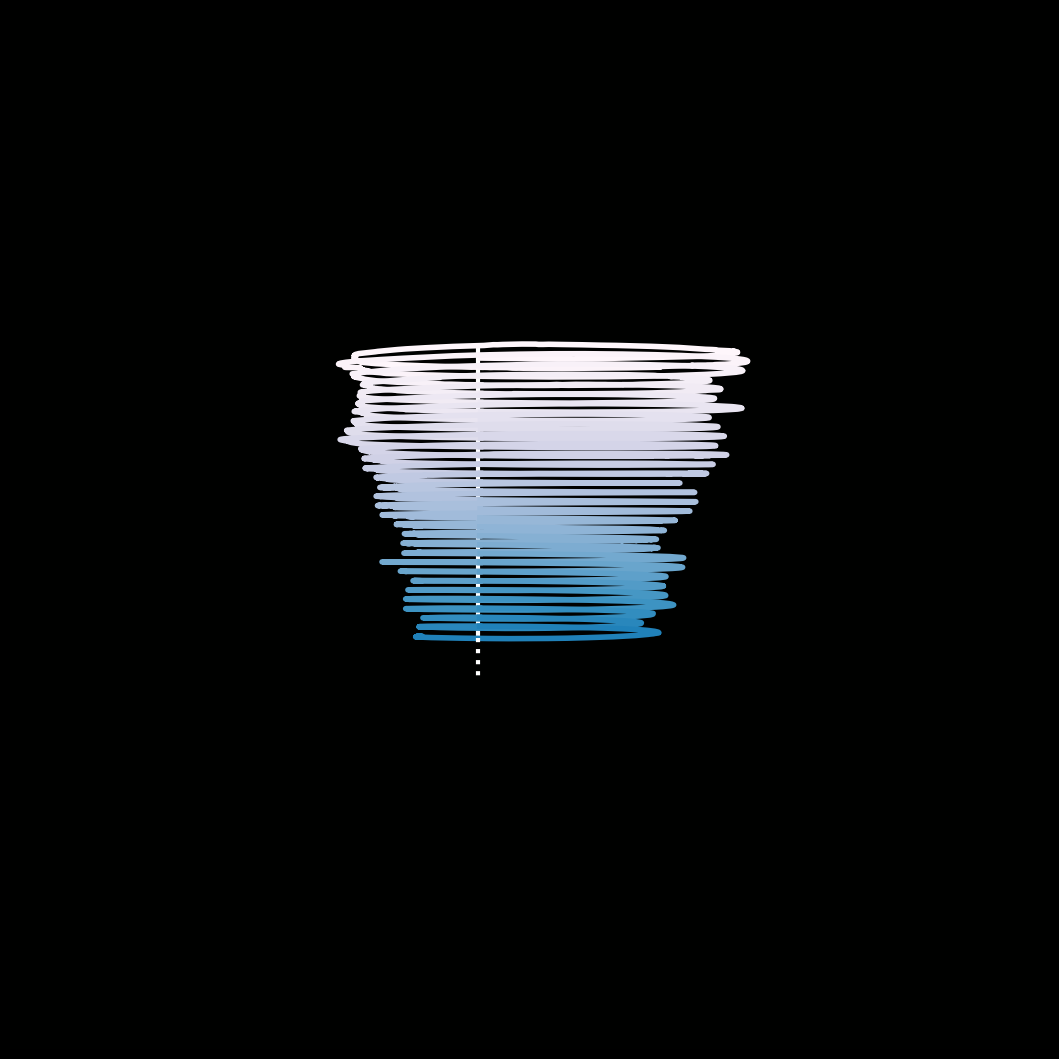

In [118]:
draw_spiral_3D(xr_vol, datetime.datetime(2022,10,31))

In [117]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

def draw_spiral_3D(vol, day, odir='', showfig=True, savefig=False):
    '''SIV spiral
    '''
    
    # identify index to plot
    chrono_tp = pd.DataFrame({'date':pd.to_datetime(xr_vol.time.to_numpy())})
    chrono_dt = np.array([dt.date() for dt in chrono_tp.date])
    t_idx = np.where(chrono_dt==day.date())[0][0]
    
    # Draw figure
    #fig, axes = plt.subplots(ncols=2, figsize=(16, 9), constrained_layout=True, facecolor='k')
    
    fig = plt.figure(figsize=(16*1.5, 9*1.5), constrained_layout=False, facecolor='k')
    # gs1 = fig.add_gridspec(nrows=20, ncols=8, left=0.05, right=0.48, wspace=0.05)
    gs1 = fig.add_gridspec(nrows=20, ncols=8, left=0.0, right=0.5, wspace=0.5)
    

    ax2 = fig.add_subplot(gs1[:, :], projection='3d')  # y, x
    ax2.set_axis_off()
#     ax.view_init(elev=30, azim=45, roll=15)
    ax2.view_init(elev=0, azim=-90, roll=0)

    ax2.dist = 15
#     ax2.elev = 
    
    # -----------------------------
    ## Volume plot
    
    full_circle_thetas = np.linspace(0, 2*np.pi, 366)
    yticks = [5,10,15,20,25]

    # plot volume rings
#     for ytick in yticks:
#         ax2.plot(full_circle_thetas, [ytick]*366, c='grey', zorder=-10, alpha=0.6)
#         ax2.text(np.pi/2, ytick, f'{ytick}', color="grey", ha='center', fontdict={'fontsize': 20})
    
    z = -np.arange(0, xr_vol.size)*2
    colors = plt.cm.YlOrRd_r(np.linspace(0, 1, xr_vol.size))
    colors = plt.cm.PuBu(np.linspace(0, .7, xr_vol.size))
    
    # plot each year with different color
    years = range(1992, 2023)
    yr_max = day.year
    for yr in range(years[0], yr_max):  # plot all full year
        if calendar.isleap(yr):
            ndays = 366  # number of days in year
        else:
            ndays=365

        theta = np.linspace(np.pi/2, -1.5*np.pi, ndays)  # or 366 if bisextil
        first_day = np.where(chrono_dt==datetime.date(yr,1,1))[0][0]
        last_day = np.where(chrono_dt==datetime.date(yr,12,31))[0][0] + 1
        vol_sliced = vol.isel(time=slice(first_day, last_day))
        clrs = colors[first_day:last_day]
        zs = z[first_day:last_day]
        x = vol_sliced/1000 * np.cos(theta)
        y = vol_sliced/1000 * np.sin(theta)
#         ax2.scatter(x, y, zs, color=clrs, s=25)

        ax2.plot(x, y, zs, lw=4, c=clrs[0])
        
    
    
    # ------------------ plot current year ---------------------------
    last_yr = day.year
    first_day = np.where(chrono_dt==datetime.date(last_yr,1,1))[0][0]
    last_vol_sliced = vol.isel(time=slice(first_day, t_idx))
    if calendar.isleap(last_yr):
        ndays = 366  # number of days in year
    else:
        ndays=365
    clrs = colors[first_day : first_day+last_vol_sliced.size]
    zs = z[first_day : first_day+last_vol_sliced.size]
    

    last_theta = np.linspace(np.pi/2, -1.5*np.pi, ndays)[:last_vol_sliced.shape[0]]
    x = last_vol_sliced/1000 * np.cos(last_theta)
    y = last_vol_sliced/1000 * np.sin(last_theta)
    
#     ax2.scatter(x, y, zs, color=clrs, s=25)
    ax2.plot(x, y, zs, color=clrs[0], lw=4)
    
        
#     if last_vol_sliced.size == 0 and last_yr==1992:  ## first day of first year
#         ax2.scatter(np.pi/2, vol.isel(time=first_day)/1000, zs, color='grey', s=50, marker='*')
#     elif last_vol_sliced.size == 0:  ## happen on the first january
#         ax2.scatter(theta[-1], vol_sliced[-1]/1000, zs, color='grey', s=50, marker='*')
#     else:
#         ax2.scatter(last_theta[-1], last_vol_sliced[-1]/1000, zs, color='grey', s=50, marker='*')
    
    # --------------------------------------------------------------
    
    # line
    ax2.plot([0]*2, [0]*2, [0,z[-1]], c='w', lw=3, zorder=-10)
    ax2.plot([0]*2, [0]*2, [z[-1], z[-1]-3500], c='w', lw=3, ls=':')
    
#     #add months labels
#     months=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
#     months_angles= np.linspace((np.pi/2)+(2*np.pi),np.pi/2,13)
#     for i, month in enumerate(months):
#         ax2.text(months_angles[i], 33, month, color="white", fontsize=15, ha="center")
    
    
    ax2.yaxis.grid(False)
    ax2.xaxis.grid(False)
    
    ax2.axes.get_yaxis().set_ticklabels([])
    ax2.axes.get_xaxis().set_ticklabels([])
    ax2.set_facecolor('#000100')

    ax2.set_ylim([0, 30])

    
    # -----------------------------
    
#     ax3.axis('off')
    
#     ax3.annotate('NERSC', xy=(1,0), xycoords='axes fraction', color='grey', ha='right', fontsize=24)
#     ax3.annotate('TOPAZ4 - TARDIS', xy=(1, -0.35), xycoords='axes fraction', color='grey', ha='right', fontsize=24)
#     ax3.annotate('Léo Edel', xy=(1, -.7), xycoords='axes fraction', color='grey', ha='right', fontsize=24)
    
#     ax3.annotate(f'{sit.time.dt.strftime("%Y %m %d").to_numpy()[t_idx]}', xy=(.5,.5),
#                  xycoords='axes fraction', ha='center', color='w', fontsize=40)
    
#     ax3.annotate(f'SIT :    {sit.isel(time=t_idx).mean().to_numpy():>6.2f}  m', xy=(.05,0),
#                  xycoords='axes fraction', ha='left', color='grey', fontsize=24)
#     ax3.annotate(f'SIV : {xr_vol.isel(time=t_idx).to_numpy():>6.0f} km³', xy=(.05, -.35),
#                  xycoords='axes fraction', ha='left', color='grey', fontsize=24)
    
    # -----------------------------
    
#     modif_plot.resize(fig, s=20, rx=20, do_annotation=False)
    
    
    ## Save figure
    if savefig:
        sdate = chrono_dt[t_idx].strftime("%Y%m%d")
        ofile = f'SIC_SIV_beautyplot_{sdate}.png'
        ofile = save_name.check(odir, ofile)
        plt.savefig(f"{odir}{ofile}", dpi=150, bbox_inches='tight')
        print(f'Saved as: {odir}{ofile}')

    if showfig:
        plt.show()

    plt.close()    
    

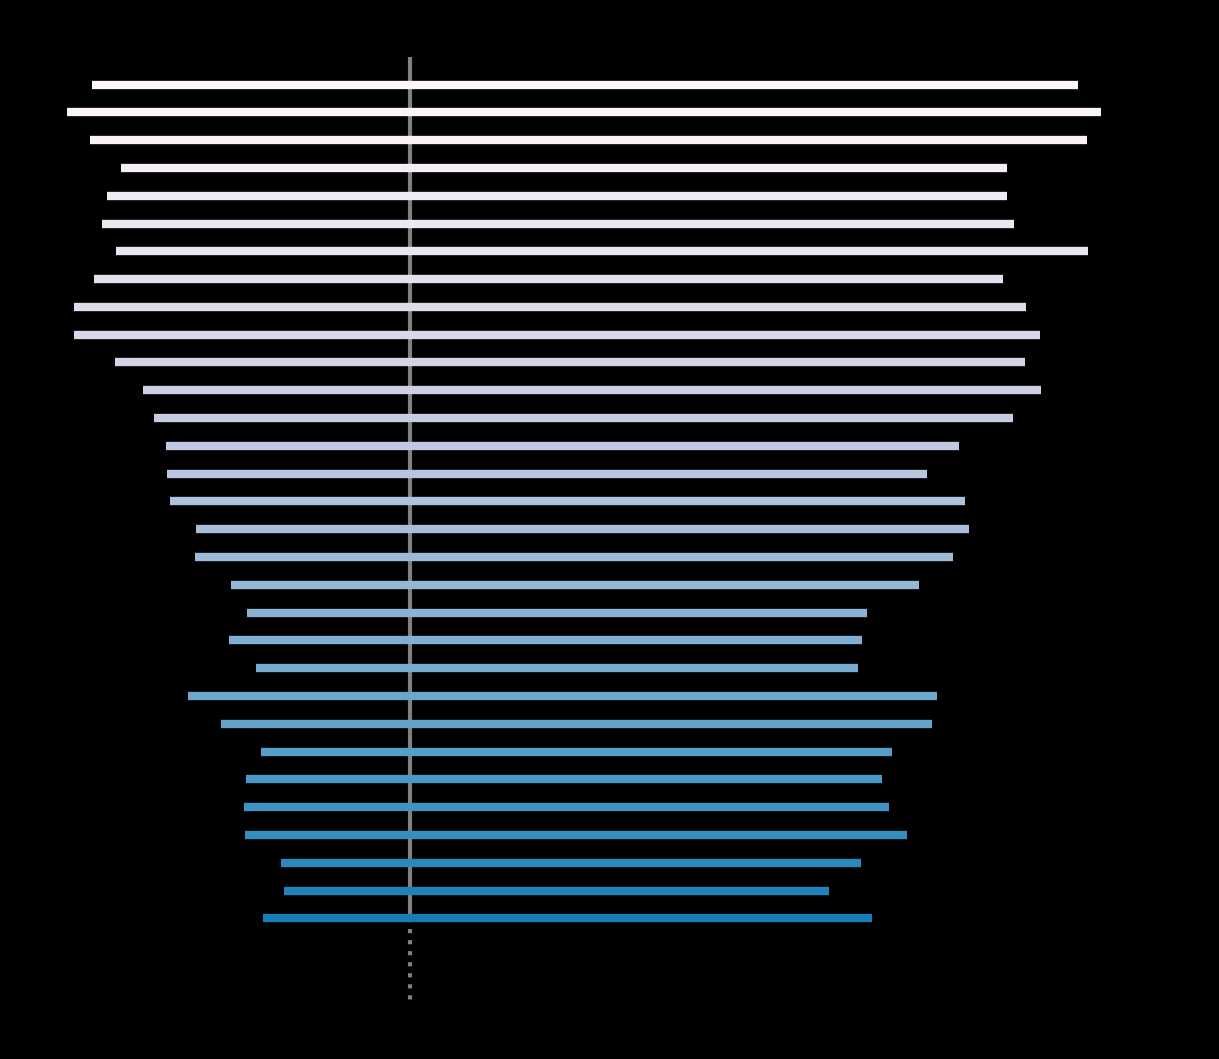

In [199]:
draw_spiral_sideview(xr_vol)

In [198]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

def draw_spiral_sideview(vol, odir='', showfig=True, savefig=False):
    '''SIV spiral flat
    '''
    
    # identify index to plot
    chrono_tp = pd.DataFrame({'date':pd.to_datetime(xr_vol.time.to_numpy())})
    chrono_dt = np.array([dt.date() for dt in chrono_tp.date])
    
    # get data the 1st october (min SIV) and the 1st April (max SIV)
    years = range(1992, 2023)
    
    oct_idx = []
    apr_idx = []
    
    for yr in years:
        oct_idx += [np.where(chrono_dt==datetime.datetime(yr,10,1).date())[0][0]]
        apr_idx += [np.where(chrono_dt==datetime.datetime(yr,4,1).date())[0][0]]
        
        
    siv_oct = vol.isel(time=oct_idx).to_numpy() /1000
    siv_apr = vol.isel(time=apr_idx).to_numpy() /1000
        
    
    # Draw figure
    fig = plt.figure(figsize=(16*1.5, 9*1.5), constrained_layout=False, facecolor='k')
    gs1 = fig.add_gridspec(nrows=20, ncols=8, left=0.0, right=0.5, wspace=0.5)
    

    ax2 = fig.add_subplot(gs1[:, :])
    ax2.set_axis_off()
    
    
    colors = plt.cm.PuBu(np.linspace(0, .7, len(years)))
    
    # -----------------------------
    ## Volume plot
    
    for ny in range(len(years)):
#         print(ny, -siv_oct[ny], siv_apr[ny])
        ax2.hlines(y=-ny, xmin=-siv_oct[ny], xmax=siv_apr[ny], colors=colors[ny], lw=6)
    
    
    
    # --------------------------------------------------------------
    
    # line
    ax2.vlines(0, 1, -30, colors='grey', lw=3, zorder=-10)
    ax2.vlines(0, -30, -33, colors='grey', lw=3, ls=':', zorder=-10)
    
    ax2.set_xlim([-15, 30])

    
    
    ## Save figure
    if savefig:
        sdate = chrono_dt[t_idx].strftime("%Y%m%d")
        ofile = f'SIC_SIV_beautyplot_{sdate}.png'
        ofile = save_name.check(odir, ofile)
        plt.savefig(f"{odir}{ofile}", dpi=150, bbox_inches='tight')
        print(f'Saved as: {odir}{ofile}')

    if showfig:
        plt.show()

    plt.close()    
    

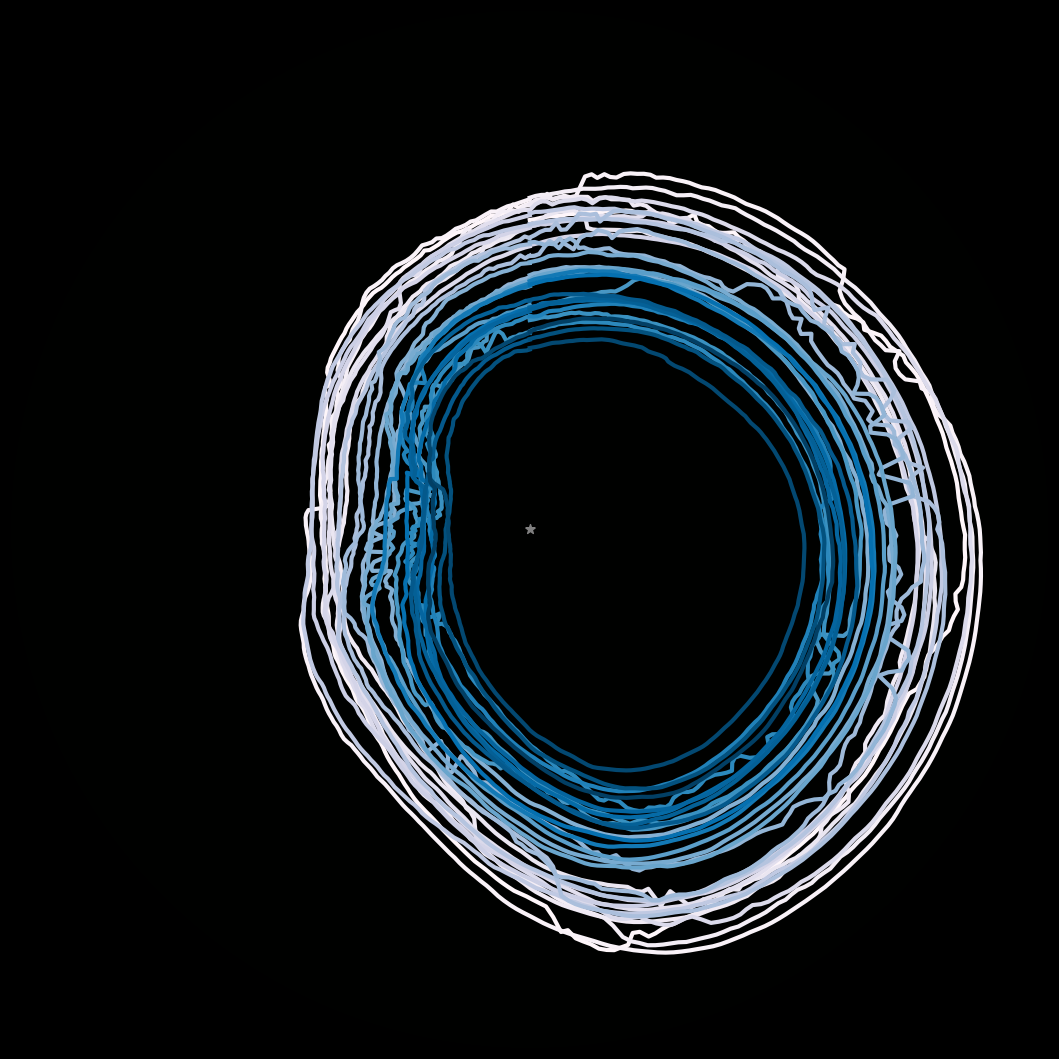

In [228]:
draw_spiral_2D(xr_vol, datetime.datetime(2022,10,31))

In [227]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

def draw_spiral_2D(vol, day, odir='', showfig=True, savefig=False):
    '''
    '''
    
    # identify index to plot
    chrono_tp = pd.DataFrame({'date':pd.to_datetime(xr_vol.time.to_numpy())})
    chrono_dt = np.array([dt.date() for dt in chrono_tp.date])
    t_idx = np.where(chrono_dt==day.date())[0][0]
    
    # Draw figure   
    fig = plt.figure(figsize=(16*1.5, 9*1.5), constrained_layout=False, facecolor='k')
    gs1 = fig.add_gridspec(nrows=20, ncols=8, left=0.0, right=0.5, wspace=0.5)
    ax2 = fig.add_subplot(gs1[:, :], projection='polar')

    # -----------------------------
    ## Volume plot
    
    full_circle_thetas = np.linspace(0, 2*np.pi, 366)

    colors = plt.cm.PuBu(np.linspace(0, 1, xr_vol.size))
    
    
    # plot each year with different color
    years = range(1992, 2023)
    yr_max = day.year
    for yr in range(years[0], yr_max):  # plot all full year
        if calendar.isleap(yr):
            ndays = 366  # number of days in year
        else:
            ndays=365

        theta = np.linspace(np.pi/2, -1.5*np.pi, ndays)  # or 366 if bisextil
        first_day = np.where(chrono_dt==datetime.date(yr,1,1))[0][0]
        last_day = np.where(chrono_dt==datetime.date(yr,12,31))[0][0] + 1
        vol_sliced = vol.isel(time=slice(first_day, last_day))
        clrs = colors[first_day:last_day]
#         ax2.scatter(theta, vol_sliced/1000, color=clrs, s=25)
        ax2.plot(theta, vol_sliced/1000, color=clrs[0], lw=3)
        
    
    
    # ------------------ plot current year ---------------------------
    last_yr = day.year
    first_day = np.where(chrono_dt==datetime.date(last_yr,1,1))[0][0]
    last_vol_sliced = vol.isel(time=slice(first_day, t_idx))
    if calendar.isleap(last_yr):
        ndays = 366  # number of days in year
    else:
        ndays=365
    clrs = colors[first_day : first_day+last_vol_sliced.size]

    last_theta = np.linspace(np.pi/2, -1.5*np.pi, ndays)[:last_vol_sliced.shape[0]]
#     ax2.scatter(last_theta, last_vol_sliced/1000, color=clrs, s=25)
    ax2.plot(last_theta, last_vol_sliced/1000, color=clrs[0], lw=3)
    
        
    ax2.scatter(0, 0, color='grey', s=50, marker='*')
    
    # --------------------------------------------------------------
    
    
    ax2.yaxis.grid(False)
    ax2.xaxis.grid(False)
    
    ax2.axes.get_yaxis().set_ticklabels([])
    ax2.axes.get_xaxis().set_ticklabels([])
    ax2.set_facecolor('#000100')

    ax2.set_ylim([0, 30])

    
    
    
    ## Save figure
    if savefig:
        sdate = chrono_dt[t_idx].strftime("%Y%m%d")
        ofile = f'SIC_SIV_beautyplot_{sdate}.png'
        ofile = save_name.check(odir, ofile)
        plt.savefig(f"{odir}{ofile}", dpi=150, bbox_inches='tight')
        print(f'Saved as: {odir}{ofile}')

    if showfig:
        plt.show()

    plt.close()    
    